In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from nettack import utils, GCN
from nettack import nettack as ntk
import numpy as np
gpu_id = None # set this to your desired GPU ID if you want to use GPU computations (only for the GCN/surrogate training)

### Load network, basic setup

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/citeseer.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)

_A_obs = _A_obs[lcc][:,lcc]

assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"
assert _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

_X_obs = _X_obs[lcc].astype('float32')
_z_obs = _z_obs[lcc]
_N = _A_obs.shape[0]
_K = _z_obs.max()+1
_Z_obs = np.eye(_K)[_z_obs]
_An = utils.preprocess_graph(_A_obs)
sizes = [16, _K]
degrees = _A_obs.sum(0).A1

seed = 15
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
np.random.seed(seed)

split_train, split_val, split_unlabeled = utils.train_val_test_split_tabular(np.arange(_N),
                                                                       train_size=train_share,
                                                                       val_size=val_share,
                                                                       test_size=unlabeled_share,
                                                                       stratify=_z_obs)

Selecting 1 largest connected components


### Choose the node to attack

In [3]:
u = 0 # node to attack
assert u in split_unlabeled

### Train surrogate model (i.e. GCN without nonlinear activation)

In [4]:
surrogate_model = GCN.GCN(sizes, _An, _X_obs, with_relu=False, name="surrogate", gpu_id=gpu_id)
surrogate_model.train(split_train, split_val, _Z_obs)
W1 =surrogate_model.W1.eval(session=surrogate_model.session)
W2 =surrogate_model.W2.eval(session=surrogate_model.session)

/home/zuegnerd/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 37 iterations


### Setup Nettack

In [5]:
nettack = ntk.Nettack(_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

In [6]:
direct_attack = True
n_influencers = 1 if direct_attack else 5
n_perturbations = int(degrees[u]) # How many perturbations to perform. Default: Degree of the node
perturb_features = True
perturb_structure = True

### Poison the data

In [7]:
nettack.reset()
nettack.attack_surrogate(n_perturbations, perturb_structure=perturb_structure, perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers)

##### Starting attack #####
##### Attack only using feature perturbations #####
##### Attacking the node directly #####
##### Performing 12 perturbations #####
##### ...1/12 perturbations ... #####
##### ...2/12 perturbations ... #####
##### ...3/12 perturbations ... #####
##### ...4/12 perturbations ... #####
##### ...5/12 perturbations ... #####
##### ...6/12 perturbations ... #####
##### ...7/12 perturbations ... #####
##### ...8/12 perturbations ... #####
##### ...9/12 perturbations ... #####
##### ...10/12 perturbations ... #####
##### ...11/12 perturbations ... #####
##### ...12/12 perturbations ... #####


In [8]:
print(nettack.structure_perturbations)

[(), (), (), (), (), (), (), (), (), (), (), ()]


In [9]:
print(nettack.feature_perturbations)

[(0, 215), (0, 65), (0, 1989), (0, 3605), (0, 1938), (0, 878), (0, 36), (0, 2974), (0, 1508), (0, 2191), (0, 3126), (0, 546)]


### Train GCN without perturbations

In [10]:
retrain_iters=5

In [11]:
classification_margins_clean = []
class_distrs_clean = []
gcn_before = GCN.GCN(sizes, _An, _X_obs, "gcn_orig", gpu_id=gpu_id)
for _ in range(retrain_iters):
    print("... {}/{} ".format(_+1, retrain_iters))
    gcn_before.train(split_train, split_val, _Z_obs)
    probs_before_attack = gcn_before.predictions.eval(session=gcn_before.session,feed_dict={gcn_before.node_ids: [nettack.u]})[0]
    class_distrs_clean.append(probs_before_attack)
    best_second_class_before = (probs_before_attack - 1000*_Z_obs[nettack.u]).argmax()
    margin_before = probs_before_attack[_z_obs[nettack.u]] - probs_before_attack[best_second_class_before]
    classification_margins_clean.append(margin_before)
class_distrs_clean = np.array(class_distrs_clean)

... 1/5 


/home/zuegnerd/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 40 iterations
... 2/5 
converged after 39 iterations
... 3/5 
converged after 45 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 34 iterations


### Train GCN with perturbations
(insert your favorite node classification algorithm here)

In [12]:
classification_margins_corrupted = []
class_distrs_retrain = []
gcn_retrain = GCN.GCN(sizes, nettack.adj_preprocessed, nettack.X_obs.tocsr(), "gcn_retrain", gpu_id=gpu_id)
for _ in range(retrain_iters):
    print("... {}/{} ".format(_+1, retrain_iters))
    gcn_retrain.train(split_train, split_val, _Z_obs)
    probs_after_attack = gcn_retrain.predictions.eval(session=gcn_retrain.session,feed_dict={gcn_retrain.node_ids: [nettack.u]})[0]
    best_second_class_after = (probs_after_attack - 1000*_Z_obs[nettack.u]).argmax()
    margin_after = probs_after_attack[_z_obs[nettack.u]] - probs_after_attack[best_second_class_after]
    class_distrs_retrain.append(probs_after_attack)
    classification_margins_corrupted.append(margin_after)
class_distrs_retrain = np.array(class_distrs_retrain)

... 1/5 


/home/zuegnerd/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 38 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 37 iterations
... 4/5 
converged after 42 iterations
... 5/5 
converged after 41 iterations


### Visualize results

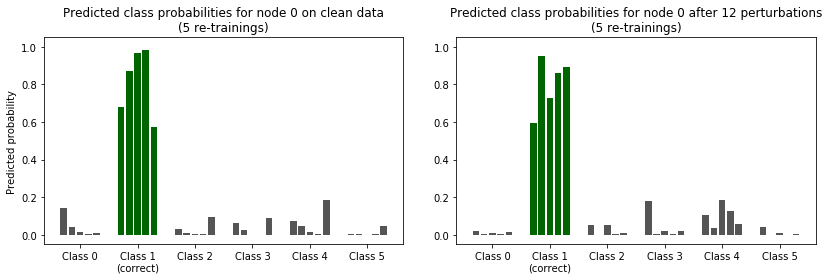

In [13]:
def make_xlabel(ix, correct):
    if ix==correct:
        return "Class {}\n(correct)".format(ix)
    return "Class {}".format(ix)

figure = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(class_distrs_clean.T):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    if ix == nettack.label_u:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)

ax=plt.gca()
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title("Predicted class probabilities for node {} on clean data\n({} re-trainings)".format(nettack.u, retrain_iters))

fig = plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(class_distrs_retrain.T):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = '#555555'
    if ix == nettack.label_u:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)


ax=plt.gca()
plt.ylim((-.05, 1.05))
ax.set_xticks(center_ixs_retrain)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title("Predicted class probabilities for node {} after {} perturbations\n({} re-trainings)".format(nettack.u, n_perturbations, retrain_iters))
plt.tight_layout()
plt.show()